In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.chdir('/content/drive/MyDrive')
if not os.path.exists('nlp_projects'):
    os.mkdir('nlp_project')
os.chdir('nlp_projects')
print(f"Current working directory: {os.getcwd()}")


Current working directory: /content/drive/MyDrive/nlp_projects


In [ ]:
import numpy as np

def load_custom_embedding(file_path):
    word_vectors = {}
    embedding_dim = None

    print(f"Loading embeddings from {file_path}...")
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            tokens = line.strip().split()
            if len(tokens) < 2:
                continue

            word = tokens[0]
            try:

                vector = np.array([float(x) for x in tokens[1:]], dtype=np.float32)

                if len(vector) != 30:
                    print(f"Warning: Skipping word '{word}' due to incorrect vector dimension {len(vector)} (expected 30)")
                    continue

                if embedding_dim is None:
                    embedding_dim = len(vector)

                word_vectors[word] = vector
            except ValueError as e:
                print(f"Warning: Skipping malformed line for word '{word}'")
                continue

    return word_vectors, embedding_dim

def combine_embeddings(embedding_files):

    combined_vectors = {}
    embedding_dim = None

    for file_path in embedding_files:
        word_vectors, dim = load_custom_embedding(file_path)

        if embedding_dim is None:
            embedding_dim = dim
        elif dim != embedding_dim:
            raise ValueError(f"Inconsistent embedding dimensions: {file_path} has dimension {dim}, expected {embedding_dim}")


        combined_vectors.update(word_vectors)

    print(f"\nFinal combined embeddings:")
    print(f"Total vocabulary size: {len(combined_vectors)}")
    print(f"Embedding dimension: {embedding_dim}")

    return combined_vectors

embedding_files = ['embedding/embed_shahab.txt', 'embedding/word_embeddings.txt', 'embedding/word_embeddings_file.txt']
pretrained_embeddings = combine_embeddings(embedding_files)


Loading embeddings from embed_shahab.txt...
Loading embeddings from word_embeddings.txt...
Loading embeddings from word_embeddings_file.txt...

Final combined embeddings:
Total vocabulary size: 2906
Embedding dimension: 30


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from collections import Counter
import os

class TextDataset(Dataset):
    def __init__(self, file_paths, seq_length, vocab=None, split_ratio=0.8, embeddings=None, embedding_dim=30):

        text = ""
        for file_path in file_paths:
            with open(file_path, 'r', encoding='utf-8') as f:
                text += f.read() + " "

        if vocab is None:
            words = text.split()
            word_counts = Counter(words)
            vocab = ['<PAD>', '<UNK>'] + [word for word, count in word_counts.most_common() if count >= 2]

        self.vocab = vocab
        self.word2idx = {word: idx for idx, word in enumerate(vocab)}
        self.idx2word = {idx: word for idx, word in enumerate(vocab)}

        self.embeddings = embeddings
        self.embedding_dim = embedding_dim
        self.seq_length = seq_length

        words = text.split()
        self.data = [self.word2idx.get(word, self.word2idx['<UNK>']) for word in words]
        split_idx = int(len(self.data) * split_ratio)
        self.train_data = self.data[:split_idx]
        self.val_data = self.data[split_idx:]

    def __len__(self):
        return len(self.train_data) - self.seq_length - 1

    def __getitem__(self, idx):
        sequence = self.train_data[idx:idx + self.seq_length]
        target = self.train_data[idx + 1:idx + self.seq_length + 1]
        return torch.tensor(sequence), torch.tensor(target)

    def get_vocab(self):
        return self.word2idx, self.idx2word

    def get_val_data(self):
        return self.val_data

    def get_embedding_matrix(self):

        embedding_matrix = np.random.randn(len(self.vocab), self.embedding_dim)

        for word, idx in self.word2idx.items():
            if word in self.embeddings:
                embedding_matrix[idx] = self.embeddings[word]

        return torch.tensor(embedding_matrix, dtype=torch.float32)

class ValDataset(Dataset):
    def __init__(self, val_data, seq_length, word2idx):
        self.data = val_data
        self.seq_length = seq_length
        self.word2idx = word2idx

    def __len__(self):
        return len(self.data) - self.seq_length - 1

    def __getitem__(self, idx):
        sequence = self.data[idx:idx + self.seq_length]
        target = self.data[idx + 1:idx + self.seq_length + 1]
        return torch.tensor(sequence), torch.tensor(target)


file_paths = ['dataset/a.txt', 'dataset/b.txt', 'dataset/c.txt']
dataset = TextDataset(file_paths=file_paths,
                      seq_length=64,
                      embeddings=pretrained_embeddings,
                      split_ratio=0.8)

word2idx, idx2word = dataset.get_vocab()

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

val_data = dataset.get_val_data()

val_dataset = ValDataset(val_data, seq_length=64, word2idx=word2idx)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

embedding_matrix = dataset.get_embedding_matrix()

for input_seq, target_seq in train_loader:
    print(f"Train batch input shape: {input_seq.shape}, target shape: {target_seq.shape}")
    break

for input_seq, target_seq in val_loader:
    print(f"Val batch input shape: {input_seq.shape}, target shape: {target_seq.shape}")
    break


Train batch input shape: torch.Size([32, 64]), target shape: torch.Size([32, 64])
Val batch input shape: torch.Size([32, 64]), target shape: torch.Size([32, 64])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import math
import os
from collections import Counter
import numpy as np


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from tqdm import tqdm

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class DecoderModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=300, nhead=8, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pos_encoder = PositionalEncoding(embedding_dim)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        self.output_layer = nn.Linear(embedding_dim, vocab_size)

        self.embedding_dim = embedding_dim

    def forward(self, src, tgt_mask=None):
        if tgt_mask is None:
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(src.size(1)).to(src.device)

        embedded = self.embedding(src)
        embedded = self.pos_encoder(embedded)

        output = self.transformer_decoder(embedded, embedded, tgt_mask=tgt_mask)
        return self.output_layer(output)

    def init_weights(self, embedding_matrix):
        self.embedding.weight.data.copy_(embedding_matrix)
        self.embedding.weight.requires_grad = False




In [ ]:
import os
checkpoint_path = 'custom_model_checkpoints'
os.makedirs(checkpoint_path, exist_ok=True)

In [34]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, num_epochs=10, device='cuda', checkpoint_interval=1):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

    best_val_loss = float('inf')

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        train_batches = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for batch_idx, (input_seq, target_seq) in enumerate(progress_bar):
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)

            optimizer.zero_grad()
            output = model(input_seq)

            loss = criterion(output.view(-1, output.size(-1)), target_seq.view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()

            total_train_loss += loss.item()
            train_batches += 1
            progress_bar.set_postfix({'loss': loss.item()})

        avg_train_loss = total_train_loss / train_batches
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        val_batches = 0

        with torch.no_grad():
            for input_seq, target_seq in val_loader:
                input_seq, target_seq = input_seq.to(device), target_seq.to(device)
                output = model(input_seq)
                loss = criterion(output.view(-1, output.size(-1)), target_seq.view(-1))
                total_val_loss += loss.item()
                val_batches += 1

        avg_val_loss = total_val_loss / val_batches
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)

        print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}')

        if (epoch + 1) % checkpoint_interval == 0:
            path_checkpoint = f'{checkpoint_path}/checkpoint_epoch_{epoch+1}.pth'
            torch.save(model.state_dict(), path_checkpoint)
            print(f'Saved checkpoint: {path_checkpoint}')

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()



Epoch 1/8: 100%|██████████| 1158/1158 [19:52<00:00,  1.03s/it, loss=5.46]


Epoch 1: Train Loss = 6.4200, Val Loss = 6.6052
Saved checkpoint: custom_model_checkpoints/checkpoint_epoch_1.pth


Epoch 2/8: 100%|██████████| 1158/1158 [19:54<00:00,  1.03s/it, loss=4.58]


Epoch 2: Train Loss = 4.9612, Val Loss = 6.4313
Saved checkpoint: custom_model_checkpoints/checkpoint_epoch_2.pth


Epoch 3/8: 100%|██████████| 1158/1158 [19:44<00:00,  1.02s/it, loss=3.93]


Epoch 3: Train Loss = 4.1081, Val Loss = 6.4242
Saved checkpoint: custom_model_checkpoints/checkpoint_epoch_3.pth


Epoch 4/8: 100%|██████████| 1158/1158 [19:42<00:00,  1.02s/it, loss=3.53]


Epoch 4: Train Loss = 3.4625, Val Loss = 6.4921
Saved checkpoint: custom_model_checkpoints/checkpoint_epoch_4.pth


Epoch 5/8: 100%|██████████| 1158/1158 [19:38<00:00,  1.02s/it, loss=3.06]


Epoch 5: Train Loss = 2.9586, Val Loss = 6.6272
Saved checkpoint: custom_model_checkpoints/checkpoint_epoch_5.pth


Epoch 6/8: 100%|██████████| 1158/1158 [19:37<00:00,  1.02s/it, loss=1.62]


Epoch 6: Train Loss = 2.5675, Val Loss = 6.7940
Saved checkpoint: custom_model_checkpoints/checkpoint_epoch_6.pth


Epoch 7/8: 100%|██████████| 1158/1158 [19:35<00:00,  1.02s/it, loss=2.03]


Epoch 7: Train Loss = 2.3111, Val Loss = 6.8900
Saved checkpoint: custom_model_checkpoints/checkpoint_epoch_7.pth


Epoch 8/8: 100%|██████████| 1158/1158 [19:36<00:00,  1.02s/it, loss=2.22]


Epoch 8: Train Loss = 2.1649, Val Loss = 6.9938
Saved checkpoint: custom_model_checkpoints/checkpoint_epoch_8.pth


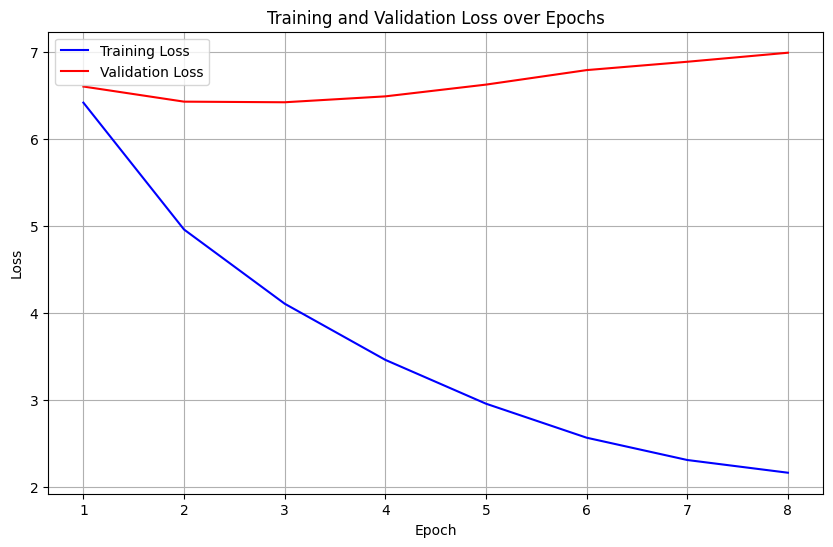

In [35]:
model = DecoderModel(
    vocab_size=len(word2idx),
    embedding_dim=30,
    nhead=6,
    num_decoder_layers=8
)

model.init_weights(embedding_matrix)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_model(model, train_loader, val_loader, num_epochs=8, device=device)

In [36]:
!pip install rouge_score
!pip install nltk


In [37]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import torch

def compute_quick_metrics(model, val_loader, word2idx, idx2word, num_samples=100, device='cuda'):

    model.eval()

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    smoother = SmoothingFunction()

    bleu_scores = []
    rouge1_scores = []
    rougeL_scores = []

    samples_processed = 0

    with torch.no_grad():
        for input_seq, target_seq in val_loader:
            batch_size = input_seq.size(0)


            current_input = input_seq[0].to(device)
            target_words = [idx2word[idx.item()] for idx in target_seq[0]]

            output = model(current_input.unsqueeze(0))
            pred_indices = torch.argmax(output[0], dim=-1)
            generated_words = [idx2word[idx.item()] for idx in pred_indices]


            bleu = sentence_bleu(
                [target_words],
                generated_words,
                smoothing_function=smoother.method1
            )
            bleu_scores.append(bleu)

            rouge_result = scorer.score(' '.join(target_words), ' '.join(generated_words))
            rouge1_scores.append(rouge_result['rouge1'].fmeasure)
            rougeL_scores.append(rouge_result['rougeL'].fmeasure)

            samples_processed += 1
            if samples_processed >= num_samples:
                break

    return {
        'bleu': sum(bleu_scores) / len(bleu_scores),
        'rouge1': sum(rouge1_scores) / len(rouge1_scores),
        'rougeL': sum(rougeL_scores) / len(rougeL_scores)
    }

In [38]:
quick_metrics = compute_quick_metrics(model, val_loader, word2idx, idx2word, num_samples=100, device=device)


print("\nValidation Metrics:")
print(f"BLEU Score: {quick_metrics['bleu']:.4f}")
print(f"ROUGE-1 F1: {quick_metrics['rouge1']:.4f}")
print(f"ROUGE-L F1: {quick_metrics['rougeL']:.4f}")


Validation Metrics:
BLEU Score: 0.1494
ROUGE-1 F1: 0.4838
ROUGE-L F1: 0.4159


In [39]:
def predict_next_words(model, input_seq, idx2word, device='cpu', max_gen_len=10):
    model.eval()

    input_seq = input_seq.unsqueeze(0).to(device)
    generated_words = []

    with torch.no_grad():
        for _ in range(max_gen_len):

            output = model(input_seq)

            pred_indices = torch.argmax(output[0], dim=-1)


            pred_word = idx2word[pred_indices[0].item()]
            generated_words.append(pred_word)

            input_seq = torch.cat((input_seq, pred_indices[-1].unsqueeze(0).unsqueeze(0).to(device)), dim=1)

            if pred_word == '<eos>':
                break

    return generated_words


In [40]:
import torch

print(torch.cuda.is_available())


False


In [41]:
input_seq_for_prediction = val_loader.dataset[0][0]
predicted_words = predict_next_words(model, input_seq_for_prediction, idx2word, device='cpu', max_gen_len=50)
print("Predicted Words:", predicted_words)

Predicted Words: ['the', 'the', 'the', 'the', 'the', 'the', 'in', 'in', 'in', 'in', 'in', 'the', 'the', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'the', 'in', 'the', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the']
